In [8]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Analysis with Ordinal Regression
In this notebook, the parsed data from FRC_Parser was analyzed using ordinal regression.  Before performing ordinal regression, some feature engineering was performed, particularly determining which features were important for each model.  For instance, for the defensive model, the autonomous features should be removed since one is penalized for touching any of the opposing alliance members during autonomous.  In addition, LASSO regularization was performed for variable selection and increased accuracy.  Finally, 

In [16]:
#Read the beta matrices into dataframes.
fileLoc = "C:\\Users\\Christian\\Documents\\GitHub\\FRC-Analyzer\\Parsed Output\\combStats_Off.csv"
temp = pd.read_csv(fileLoc,index_col=0)
beta_Off = temp.loc[:, temp.columns != 'rank']
rank_Off = temp.loc[:, temp.columns == 'rank']
print(beta_Off.columns.values)
beta_Off.head(10)

fileLoc = "C:\\Users\\Christian\\Documents\\GitHub\\FRC-Analyzer\\Parsed Output\\combStats_Def.csv"
temp = pd.read_csv(fileLoc,index_col=0)
beta_Def = temp.loc[:, temp.columns != 'rank']
rank_Def = temp.loc[:, temp.columns == 'rank']
beta_Def.head(10)

['autoRobot.None' 'autoRobot.AutoRun' 'endgameRobot.None'
 'endgameRobot.Parking' 'endgameRobot.Climbing' 'endgameRobot.Levitate'
 'endgameRobot.Unknown' 'adjustPoints' 'autoOwnershipPoints' 'autoPoints'
 'autoQuestRankingPoint' 'autoRunPoints' 'autoScaleOwnershipSec'
 'autoSwitchAtZero' 'autoSwitchOwnershipSec' 'endgamePoints'
 'faceTheBossRankingPoint' 'foulCount' 'foulPoints' 'rp'
 'tba_gameData_LLL' 'tba_gameData_LRL' 'tba_gameData_RLR'
 'tba_gameData_RRR' 'techFoulCount' 'teleopOwnershipPoints' 'teleopPoints'
 'teleopScaleBoostSec' 'teleopScaleForceSec' 'teleopScaleOwnershipSec'
 'teleopSwitchBoostSec' 'teleopSwitchForceSec' 'teleopSwitchOwnershipSec'
 'totalPoints' 'vaultBoostPlayed' 'vaultBoostTotal' 'vaultForcePlayed'
 'vaultForceTotal' 'vaultLevitatePlayed' 'vaultLevitateTotal'
 'vaultPoints']


autoRobot.None  autoRobot.AutoRun  endgameRobot.None  \
frc1011               0                  9                  2   
frc1138               1                  8                  1   
frc1165               1                  8                  1   
frc1492               0                  9                  0   
frc1828               6                  3                  8   
frc1836               0                  9                  0   
frc2073               6                  3                  5   
frc2122               0                  9                  0   
frc2135               1                  8                  2   
frc2375               2                  7                  2   

         endgameRobot.Parking  endgameRobot.Climbing  endgameRobot.Levitate  \
frc1011                     3                      1                      3   
frc1138                     4                      3                      1   
frc1165                     7                      0                      1   
frc1492                     7                      0                      2   
frc1828                     0                      0                      1   
frc1836                     2                      2                      5   
frc2073                     2                      0                      2   
frc2122                     5                      0                      4   
frc2135                     6                      1                      0   
frc2375                     4                      0                      3   

         endgameRobot.Unknown  adjustPoints  autoOwnershipPoints  autoPoints  \
frc1011                     0           0.0            -5.988145   -2.374308   
frc1138                     0           0.0             0.436460    3.160595   
frc1165                     0           0.0             6.388329   10.480164   
frc1492                     0           0.0             2.056842    7.083684   
frc1828                     0           0.0            -2.011112    2.479637   
frc1836                     0           0.0            11.344820   15.585831   
frc2073                     0           0.0             2.000373    5.832667   
frc2122                     0           0.0            -0.697102    3.067424   
frc2135                     0           0.0             2.230771    6.941917   
frc2375                     0           0.0            -0.079743    3.580586   

            ...       teleopSwitchForceSec  teleopSwitchOwnershipSec  \
frc1011     ...                  -0.901581                -27.794169   
frc1138     ...                   1.222854                 29.131349   
frc1165     ...                  -0.474478                 57.903979   
frc1492     ...                  -1.115645                 44.373917   
frc1828     ...                  -0.415867                 18.152114   
frc1836     ...                   1.168729                  3.338760   
frc2073     ...                   0.618798                 33.571822   
frc2122     ...                   1.696737                 16.245898   
frc2135     ...                   2.577232                 56.916077   
frc2375     ...                  -1.023239                 29.589669   

         totalPoints  vaultBoostPlayed  vaultBoostTotal  vaultForcePlayed  \
frc1011   -22.561678         -0.662202        -0.381198         -0.236885   
frc1138    81.196106          0.188735         0.344464          0.155470   
frc1165   140.047780          0.765376         0.924305          0.601972   
frc1492    75.942624          0.199561         0.012820         -0.397862   
frc1828    42.574413          1.034487         0.955254          0.293551   
frc1836    94.438884         -0.025984        -0.333536          0.333031   
frc2073    82.708019         -0.089901        -0.031341          0.023829   
frc2122    -5.387790         -0.453328        -0.218019          0.132231   
frc2135   118.974836          0.637752         0.792226 

## Correlation Plots

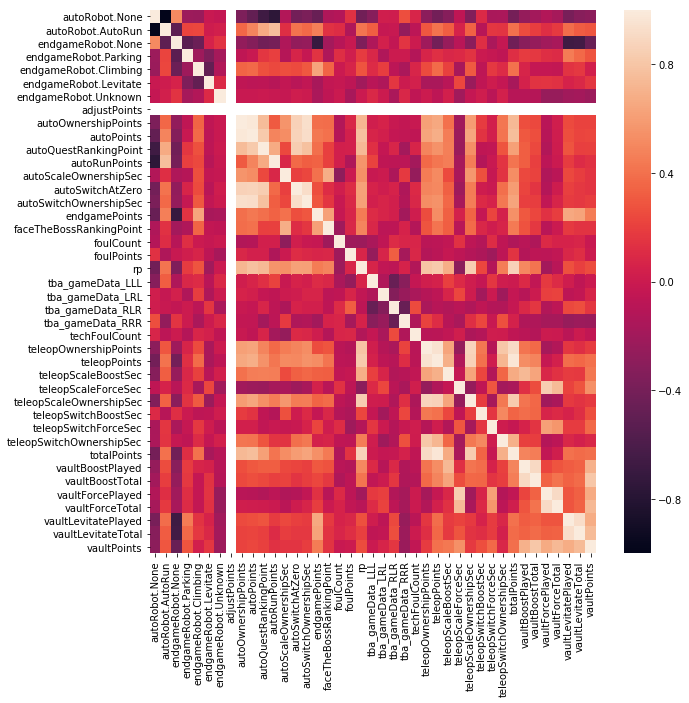

In [17]:
#Correlation matrix for offense beta matrix
fig, ax = plt.subplots(figsize=(10, 10))
# pass the axis to draw on
corr = beta_Off.corr()
sns.heatmap(corr, ax=ax)

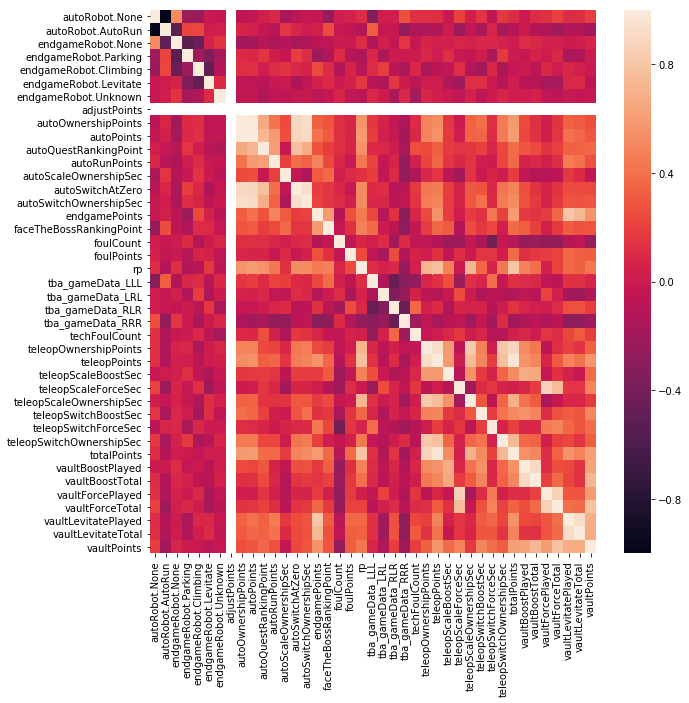

In [18]:
#Correlation matrix for defense beta matrix
fig, ax = plt.subplots(figsize=(10, 10))
# pass the axis to draw on
corr = beta_Def.corr()
sns.heatmap(corr, ax=ax)

## Strongest Absolute Correlations

In [19]:
#Functions to list the largest correlations
def get_redundant_pairs(corr):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = corr.columns
    for i in range(0, corr.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr, n=5):
    au_corr = pd.Series(corr.abs().unstack(), name='Abs')
    sign_corr = np.sign(corr)
    si_corr = pd.Series(sign_corr.unstack(), name='Sign')
    
    labels_to_drop = get_redundant_pairs(corr)
    
    au_corr = au_corr.drop(labels=labels_to_drop)
    si_corr = si_corr.drop(labels=labels_to_drop)
    
    corr_Val_Sign = pd.concat([au_corr,si_corr], axis=1)
    corr_Val_Sign = corr_Val_Sign.sort_values(by='Abs',ascending=False)    
    return corr_Val_Sign[0:n].Abs*corr_Val_Sign[0:n].Sign

In [20]:
#Removed "adjustPoints" from beta matrices
beta_Off = beta_Off.drop(['adjustPoints'], axis=1)
beta_Def = beta_Def.drop(['adjustPoints'], axis=1)
corr_Off = beta_Off.corr()
corr_Def = beta_Def.corr()

print("-------------------------------------")
print("-Top Absolute Correlations (Offense)-")
print("-------------------------------------")
print(get_top_abs_correlations(corr_Off, 1000))

print("-------------------------------------")
print("-Top Absolute Correlations (Defense)-")
print("-------------------------------------")
print(get_top_abs_correlations(corr_Def, 1000))

-------------------------------------
-Top Absolute Correlations (Offense)-
-------------------------------------
autoRobot.None           autoRobot.AutoRun          -1.000000
autoOwnershipPoints      autoPoints                  0.980579
teleopPoints             totalPoints                 0.969691
teleopOwnershipPoints    teleopPoints                0.949111
autoOwnershipPoints      autoSwitchOwnershipSec      0.934630
autoSwitchAtZero         autoSwitchOwnershipSec      0.929128
vaultLevitatePlayed      vaultLevitateTotal          0.925776
autoPoints               autoSwitchOwnershipSec      0.924327
teleopOwnershipPoints    totalPoints                 0.910791
vaultForcePlayed         vaultForceTotal             0.910574
vaultBoostPlayed         vaultBoostTotal             0.904947
teleopOwnershipPoints    teleopScaleOwnershipSec     0.875596
autoPoints               autoSwitchAtZero            0.869915
autoOwnershipPoints      autoSwitchAtZero            0.864186
teleopPoints      

In [21]:
#Modify and remove columns that 

## Variance Inflation Factors

In [22]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(beta_Off.values, i) for i in range(beta_Off.shape[1])]
vif["features"] = beta_Off.columns
vif.head(100)

C:\Users\Christian\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF Factor                  features
0            inf            autoRobot.None
1            inf         autoRobot.AutoRun
2            inf         endgameRobot.None
3            inf      endgameRobot.Parking
4            inf     endgameRobot.Climbing
5            inf     endgameRobot.Levitate
6            inf      endgameRobot.Unknown
7            inf       autoOwnershipPoints
8            inf                autoPoints
9   1.818660e+01     autoQuestRankingPoint
10           inf             autoRunPoints
11           inf     autoScaleOwnershipSec
12  2.059291e+01          autoSwitchAtZero
13           inf    autoSwitchOwnershipSec
14           inf             endgamePoints
15  6.686350e+00   faceTheBossRankingPoint
16  2.430864e+00                 foulCount
17  3.558800e+05                foulPoints
18  2.080898e+01                        rp
19           inf          tba_gameData_LLL
20           inf          tba_gameData_LRL
21           inf          tba_gameData_RLR
22           inf          tba_gameData_RRR
23  1.866162e+00             techFoulCount
24           inf     teleopOwnershipPoints
25           inf              teleopPoints
26           inf       teleopScaleBoostSec
27  9.433537e+00       teleopScaleForceSec
28           inf   teleopScaleOwnershipSec
29           inf      teleopSwitchBoostSec
30  5.414800e+00      teleopSwitchForceSec
31           inf  teleopSwitchOwnershipSec
32  8.141905e+06               totalPoints
33  1.972982e+01          vaultBoostPlayed
34           inf           vaultBoostTotal
35  2.230013e+01          vaultForcePlayed
36           inf           vaultForceTotal
37  1.545950e+01       vaultLevitatePlayed
38           inf        vaultLevitateTotal
39           inf               vaultPoints